In [33]:
from dataset_preprocesser import MVTecAD2
from torchvision                        import transforms
from matplotlib import pyplot as plt
import yaml
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import os
from tqdm import tqdm

In [30]:
# Load configuration from config.yaml
# Look for the config.yaml file in the current directory
config_path = os.path.join(os.getcwd(), "config.yaml")
with open(config_path, "r") as file:
    config = yaml.safe_load(file)
OUTPUT_PATH = config.get("OUTPUT_PATH", "")

In [5]:
transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

In [6]:
train_dataset = MVTecAD2("hazelnut","train",OUTPUT_PATH,transform=transform)
test_dataset = MVTecAD2("hazelnut","test",OUTPUT_PATH,transform=transform)

In [38]:
list(train_dataset.__getitem__(0))

['sample', 'image_path', 'rel_out_path_cont', 'rel_out_path_thresh']

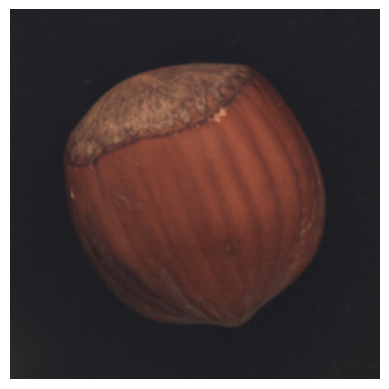

In [7]:
image = train_dataset.__getitem__(0)["sample"]
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()

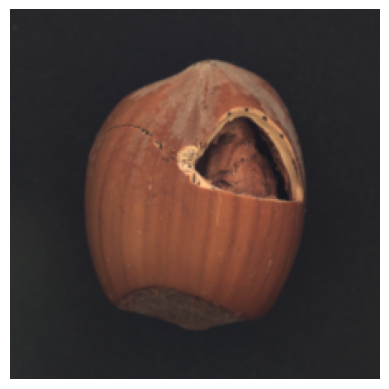

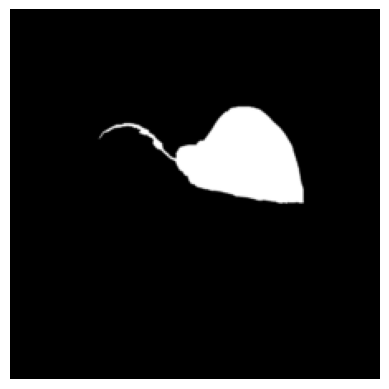

In [8]:
image = test_dataset.__getitem__(0)["sample"]
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()
image = test_dataset.__getitem__(0)["ht"]
plt.imshow(image.squeeze(0), cmap='gray')
plt.axis('off')
plt.show()

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # (B, 64, 112, 112)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (B, 128, 56, 56)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (B, 256, 28, 28)
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 128, 56, 56)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 64, 112, 112)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 3, 224, 224)
            nn.Sigmoid(),  # Normalize output to [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [66]:
# Instantiate the autoencoder
autoencoder = Autoencoder()
# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [67]:
print(autoencoder)
# Calculate the total number of parameters in the autoencoder
total_params = sum(p.numel() for p in autoencoder.parameters())
print(f"Total number of parameters in the autoencoder: {total_params}")

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)
Total number of parameters in the autoencoder: 741379


In [70]:
config_path = os.path.join(os.getcwd(), "config.yaml")
with open(config_path, "r") as file:
    config = yaml.safe_load(file)
# Read training parameters from config.ipynb
models_config = config.get("MODELS_CONFIG", {})
base_autoencoder_config = models_config.get("base_autoencoder", {})
batch_size = base_autoencoder_config.get("batch_size")
num_epochs = base_autoencoder_config.get("num_epochs")
validation_split = base_autoencoder_config.get("validation_split")
base_autoencoder_config

{'batch_size': 16, 'num_epochs': 30, 'validation_split': 0.1}

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the autoencoder to the appropriate device
autoencoder.to(device)

# Create a DataLoader for the training dataset
# Split the training dataset into training and validation sets
val_size = int(validation_split * len(train_dataset))
train_size = len(train_dataset) - val_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for the training and validation subsets
train_loader = DataLoader(train_subset, 
                          batch_size=batch_size, 
                          shuffle=True,
                          num_workers=8)

val_loader = DataLoader(val_subset, 
                        batch_size=batch_size, 
                        shuffle=False,
                        num_workers=8)

In [74]:
# Training loop with validation
for epoch in range(num_epochs):
    # Training phase
    autoencoder.train()
    epoch_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        # Get the input images and move them to the device
        inputs = batch["sample"].to(device)

        # Forward pass
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

    # Print training loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss / len(train_loader):.4f}")

    # Validation phase with reconstruction error metric
    autoencoder.eval()
    val_loss = 0.0
    reconstruction_errors = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
            # Get the input images and move them to the device
            inputs = batch["sample"].to(device)

            # Forward pass
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)

            # Compute per-image reconstruction error
            per_image_error = torch.mean((inputs - outputs) ** 2, dim=(1, 2, 3))
            reconstruction_errors.extend(per_image_error.cpu().numpy())

            # Accumulate validation loss
            val_loss += loss.item()

    # Print validation loss and reconstruction error statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss / len(val_loader)}")
    print(f"Reconstruction Error - Mean: {torch.tensor(reconstruction_errors).mean()}, "
          f"Std: {torch.tensor(reconstruction_errors).std()}")

Epoch 1/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  3.70it/s]


Epoch [1/30], Training Loss: 0.0095


Epoch 1/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


Epoch [1/30], Validation Loss: 0.00554858644803365
Reconstruction Error - Mean: 0.005557180382311344, Std: 0.0013842987827956676


Epoch 2/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  3.70it/s]


Epoch [2/30], Training Loss: 0.0039


Epoch 2/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Epoch [2/30], Validation Loss: 0.0020245634174595275
Reconstruction Error - Mean: 0.0020333826541900635, Std: 0.0007751793600618839


Epoch 3/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  4.21it/s]


Epoch [3/30], Training Loss: 0.0011


Epoch 3/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


Epoch [3/30], Validation Loss: 0.0006459425009476641
Reconstruction Error - Mean: 0.0006488313665613532, Std: 0.0002366135740885511


Epoch 4/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  3.88it/s]


Epoch [4/30], Training Loss: 0.0006


Epoch 4/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


Epoch [4/30], Validation Loss: 0.00045010619214735925
Reconstruction Error - Mean: 0.0004522934032138437, Std: 0.00014810741413384676


Epoch 5/30 - Training: 100%|██████████| 22/22 [00:06<00:00,  3.61it/s]


Epoch [5/30], Training Loss: 0.0004


Epoch 5/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


Epoch [5/30], Validation Loss: 0.00038200348111179966
Reconstruction Error - Mean: 0.00038444975507445633, Std: 0.00011886722495546564


Epoch 6/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  3.79it/s]


Epoch [6/30], Training Loss: 0.0004


Epoch 6/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Epoch [6/30], Validation Loss: 0.0003467219842908283
Reconstruction Error - Mean: 0.00034931203117594123, Std: 0.0001056063556461595


Epoch 7/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  3.75it/s]


Epoch [7/30], Training Loss: 0.0004


Epoch 7/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


Epoch [7/30], Validation Loss: 0.0003193108520160119
Reconstruction Error - Mean: 0.00032187148462980986, Std: 9.854702511802316e-05


Epoch 8/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  4.17it/s]


Epoch [8/30], Training Loss: 0.0003


Epoch 8/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


Epoch [8/30], Validation Loss: 0.0002952727469770859
Reconstruction Error - Mean: 0.00029770113178528845, Std: 9.152331767836586e-05


Epoch 9/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  3.72it/s]


Epoch [9/30], Training Loss: 0.0003


Epoch 9/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


Epoch [9/30], Validation Loss: 0.0002772974839899689
Reconstruction Error - Mean: 0.00027975786360912025, Std: 8.752951544011012e-05


Epoch 10/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  4.08it/s]


Epoch [10/30], Training Loss: 0.0003


Epoch 10/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


Epoch [10/30], Validation Loss: 0.00026459966708595556
Reconstruction Error - Mean: 0.000267021736362949, Std: 8.371088915737346e-05


Epoch 11/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  4.02it/s]


Epoch [11/30], Training Loss: 0.0003


Epoch 11/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


Epoch [11/30], Validation Loss: 0.00024639482823355746
Reconstruction Error - Mean: 0.0002489963371772319, Std: 8.425732812611386e-05


Epoch 12/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  4.03it/s]


Epoch [12/30], Training Loss: 0.0003


Epoch 12/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]


Epoch [12/30], Validation Loss: 0.00023924222720476487
Reconstruction Error - Mean: 0.00024180691980291158, Std: 8.115912351058796e-05


Epoch 13/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  3.92it/s]


Epoch [13/30], Training Loss: 0.0002


Epoch 13/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


Epoch [13/30], Validation Loss: 0.00023170132287001857
Reconstruction Error - Mean: 0.00023417103511746973, Std: 7.835394353605807e-05


Epoch 14/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  3.82it/s]


Epoch [14/30], Training Loss: 0.0003


Epoch 14/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]


Epoch [14/30], Validation Loss: 0.000248366753415515
Reconstruction Error - Mean: 0.0002507659955881536, Std: 8.05680247140117e-05


Epoch 15/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  4.14it/s]


Epoch [15/30], Training Loss: 0.0002


Epoch 15/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]


Epoch [15/30], Validation Loss: 0.00021620650659315288
Reconstruction Error - Mean: 0.00021861978166271, Std: 7.647391612408683e-05


Epoch 16/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  3.96it/s]


Epoch [16/30], Training Loss: 0.0002


Epoch 16/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


Epoch [16/30], Validation Loss: 0.00021757351350970566
Reconstruction Error - Mean: 0.0002198241709265858, Std: 7.389418897219002e-05


Epoch 17/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  4.10it/s]


Epoch [17/30], Training Loss: 0.0002


Epoch 17/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


Epoch [17/30], Validation Loss: 0.00020558753264291832
Reconstruction Error - Mean: 0.00020773947471752763, Std: 7.11490647518076e-05


Epoch 18/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  4.08it/s]


Epoch [18/30], Training Loss: 0.0002


Epoch 18/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]


Epoch [18/30], Validation Loss: 0.0002011213703857114
Reconstruction Error - Mean: 0.00020299469179008156, Std: 6.818844849476591e-05


Epoch 19/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  4.06it/s]


Epoch [19/30], Training Loss: 0.0002


Epoch 19/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


Epoch [19/30], Validation Loss: 0.00020342014613561332
Reconstruction Error - Mean: 0.0002054710203083232, Std: 6.811464118072763e-05


Epoch 20/30 - Training: 100%|██████████| 22/22 [00:06<00:00,  3.64it/s]


Epoch [20/30], Training Loss: 0.0002


Epoch 20/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


Epoch [20/30], Validation Loss: 0.0001934817167542254
Reconstruction Error - Mean: 0.00019554339814931154, Std: 6.742857658537105e-05


Epoch 21/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s]


Epoch [21/30], Training Loss: 0.0002


Epoch 21/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


Epoch [21/30], Validation Loss: 0.00019255950852918127
Reconstruction Error - Mean: 0.00019451419939287007, Std: 6.659779319306836e-05


Epoch 22/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  4.02it/s]


Epoch [22/30], Training Loss: 0.0002


Epoch 22/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]


Epoch [22/30], Validation Loss: 0.00019428832456469536
Reconstruction Error - Mean: 0.00019644852727651596, Std: 6.68432840029709e-05


Epoch 23/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  3.80it/s]


Epoch [23/30], Training Loss: 0.0002


Epoch 23/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


Epoch [23/30], Validation Loss: 0.00018185232086883238
Reconstruction Error - Mean: 0.0001836910960264504, Std: 6.450081127695739e-05


Epoch 24/30 - Training: 100%|██████████| 22/22 [00:06<00:00,  3.59it/s]


Epoch [24/30], Training Loss: 0.0002


Epoch 24/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Epoch [24/30], Validation Loss: 0.0001783238403731957
Reconstruction Error - Mean: 0.00018000371346715838, Std: 6.199770723469555e-05


Epoch 25/30 - Training: 100%|██████████| 22/22 [00:06<00:00,  3.65it/s]


Epoch [25/30], Training Loss: 0.0002


Epoch 25/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


Epoch [25/30], Validation Loss: 0.00027255871100351214
Reconstruction Error - Mean: 0.0002735161397140473, Std: 5.755504753324203e-05


Epoch 26/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  3.86it/s]


Epoch [26/30], Training Loss: 0.0002


Epoch 26/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


Epoch [26/30], Validation Loss: 0.00017967287567444146
Reconstruction Error - Mean: 0.0001812184345908463, Std: 6.0906018916284665e-05


Epoch 27/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  4.14it/s]


Epoch [27/30], Training Loss: 0.0002


Epoch 27/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


Epoch [27/30], Validation Loss: 0.00016758205310907215
Reconstruction Error - Mean: 0.00016899996262509376, Std: 5.929612962063402e-05


Epoch 28/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  4.32it/s]


Epoch [28/30], Training Loss: 0.0002


Epoch 28/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch [28/30], Validation Loss: 0.00016432089129618058
Reconstruction Error - Mean: 0.00016585933917667717, Std: 5.860870805918239e-05


Epoch 29/30 - Training: 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]


Epoch [29/30], Training Loss: 0.0002


Epoch 29/30 - Validation: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


Epoch [29/30], Validation Loss: 0.00019740462206148854
Reconstruction Error - Mean: 0.0001990367309190333, Std: 6.146136729512364e-05


Epoch 30/30 - Training: 100%|██████████| 22/22 [00:05<00:00,  3.86it/s]


Epoch [30/30], Training Loss: 0.0002


Epoch 30/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

Epoch [30/30], Validation Loss: 0.00016623971168883145
Reconstruction Error - Mean: 0.00016759739082772285, Std: 5.670597238349728e-05


In [75]:
# Save the model weights
weights_path = os.path.join(OUTPUT_PATH, "autoencoder_weights")
os.makedirs( weights_path, exist_ok=True)

model_save_path = os.path.join(weights_path, "autoencoder_weights.pth")
torch.save(autoencoder.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

Model weights saved to /home/jaspinder/Github/Anomaly_Detection/autoencoder_weights/autoencoder_weights.pth


In [ ]:
from PIL import Image
import numpy as np
from tqdm import tqdm

# Set the autoencoder to evaluation mode
autoencoder.eval()
anomaly_scores = []
# Perform inference on the test dataset
for el in tqdm(train_dataset, desc="Processing train dataset"):
    # Get the input image and its path
    sample      = el["sample"].to(device)
    output_path = el["rel_out_path_thresh"]
    # Perform forward pass to get the reconstructed image
    with torch.no_grad():
        reconstructed = autoencoder(sample)

    # Convert the reconstructed image to a format suitable for saving
    reconstructed_image = reconstructed.squeeze(0).permute(1, 2, 0).cpu().numpy()
    reconstructed_image = (reconstructed_image * 255).astype(np.uint8)
    # Save the reconstructed image
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    Image.fromarray(reconstructed_image).save(output_path)

    # Compute the squared difference between the input and reconstructed image
    squared_difference = (sample - reconstructed) ** 2

    # Compute the mean along the channels
    difference_image = torch.mean(squared_difference, dim=0).squeeze(0).cpu().numpy()
    # Compute the anomaly score
    anomaly_score = np.mean(difference_image)
    anomaly_scores.append(anomaly_score)

    # Normalize the difference image to the range [0, 255]
    difference_image = (difference_image * 255).astype(np.uint8)

    # Save the difference image (mask)
    mask_output_path = output_path.replace(".png", "_mask.png")
    Image.fromarray(difference_image).save(mask_output_path)
print(f"Reconstructed images saved to {output_path}")
# Print the mean anomaly score
print(f"Mean Anomaly Score: {np.mean(anomaly_scores)}")

Processing train dataset: 100%|██████████| 391/391 [00:57<00:00,  6.76it/s]

Reconstructed images saved to /home/jaspinder/Github/Anomaly_Detection/anomaly_images_thresholded/hazelnut/train/good/390.png
Mean Anomaly Score: 0.00017332810966763645
